In [1]:
from dask.distributed import Client

client = Client("tls://192.168.197.224:8786")
client

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<Client: 'tls://192.168.197.224:8786' processes=121 threads=121, memory=349.34 GiB>

In [2]:
import os
import numpy as np
import awkward as ak
import correctionlib

import dask
import copy
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents.methods import vector
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from coffea.nanoevents import NanoEventsFactory, BaseSchema

/tmp/ipykernel_35931/3618735414.py:12: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [3]:
class Processor(processor.ProcessorABC):
    def __init__(self, NTUPLE=False):
        self.NTUPLE = NTUPLE
        self.h_zboson_pt = (
            hda.Hist.new
            .Log(50, 2.5, 2500., name="zboson_pt")
            .Weight()
        )
        self.h_zboson_mass = (
            hda.Hist.new
            .Log(50, 2.5, 250., name="zboson_mass")
            .Weight()
        )
        '''
        self.h2d_pho_pt_weight = (
            hda.Hist.new
           .Regular(50, 0., 250., name="pho_pt")
           .Regular(51, 0, 1.02, name="weights")
           .Double()
        )
        '''
        pass

    def getPtEtaPhiM(self, events, obj_name):
        if "MET" in obj_name:
            vars = ["pt", "phi"]
        elif "Photon" in obj_name:
            vars = ["pt", "eta", "phi"]
        else:
            vars = ["pt", "eta", "phi", "mass"]
        return {var: events[f"{obj_name}_{var}"] for var in vars}

    def getObjects(self, events, obj_name, adds=[]):
        out = self.getPtEtaPhiM(events, obj_name)
        if adds:
            out.update({add: events[f"{obj_name}_{add}"] for add in adds})
        reqs = {"pt", "eta", "phi", "mass"}
        if not "mass" in out.keys():
            out["mass"] = out["pt"] * 0.
        is_4d_mom = reqs.issubset(out.keys())
        return ak.zip(out, with_name="LorentzVector", behavior=vector.behavior) if is_4d_mom else ak.zip(out, with_name="TwoVector", behavior=vector.behavior)

    def getGenLeptons(self, events):
        return self.getObjects(events, "GenDressedLepton")
    
    def getGenJets(self, events):
        return self.getObjects(events, "GenJet")
    
    def getGenerators(self, events):
        vars = ["id1", "id2", "scalePDF", "x1", "x2", "xpdf1", "xpdf2"]
        return ak.zip({var: events[f"Generator_{var}"] for var in vars})
    
    def process(self, events):
        weights = ak.ones_like(events.genWeight)
        gens = self.getGenerators(events)

        leptons = self.getGenLeptons(events)
        MASK_leptons = (ak.num(leptons, axis=1) > 1)
        
        weights = weights[MASK_leptons]
        leptons = leptons[MASK_leptons]
        gens = gens[MASK_leptons]
        
        zboson = leptons[:,0] + leptons[:,1]


        self.h_zboson_pt.fill(zboson_pt=zboson.pt, weight=weights)
        
        return {
            "h_zboson_pt" : self.h_zboson_pt,
        }
    def postprocess(self, accumulator):
        pass

In [6]:
datasets = []
datasets.append({"dy" : {f"root://xcache/{sample.strip()}" : "Events" for sample in open("samples.txt").readlines()}})

In [7]:
outs = []
for dataset in datasets:
    dataset_runnable, dataset_updated = preprocess(
        dataset,
        align_clusters=False,
        step_size=100_000,
        files_per_batch=1,
        skip_bad_files=True,
        save_form=False,
    )
    to_compute = apply_to_fileset(
        Processor(True),
        max_chunks(dataset_runnable, 10),
        schemaclass=BaseSchema,
    )
    (out,) = dask.compute(to_compute)
    outs.append(out)

OSError: File did not vector_read properly: [ERROR] Server responded with an error: [3005] Unable to readv /store/mc/Run3Summer22EENanoAODv12/DYto2L-4Jets_MLL-50_TuneCP5_13p6TeV_madgraphMLM-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6_ext1-v2/2520000/0b377ebc-89c0-487f-995a-a344255c11e3.root; too many levels of symbolic links


In [ ]:
out = outs[0]["GJ-4Jets-2NLO2LO_Bin-PTG-25_Par-BiasedPTG_TuneSherpaDef_13p6TeV_sherpaMEPS"]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9e12c629e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

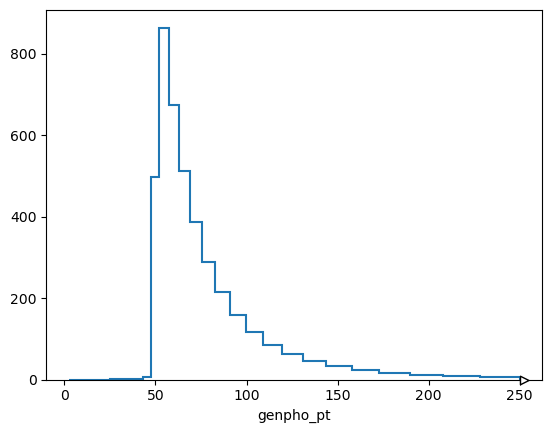

In [10]:
out["h_genpho_pt"].plot()